In [1]:
import virga.justdoit as jdi
import xarray as xr
import virga.justplotit as jpi
import glob
import pandas as pd
import astropy.units as u
pd = jdi.pd
jpi.output_notebook()
import bokeh.palettes as pals
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import picaso.justdoit as pjdi
import astropy.constants as c

Loading BokehJS ...

/Users/adityasengupta/projects/clouds/picaso/picaso/justdoit.py:2078: SyntaxWarning: invalid escape sequence '\s'
  ptchem = pd.read_csv(os.path.join(sonora_path,build_filename),sep='\s+',compression='gzip')
/Users/adityasengupta/projects/clouds/picaso/picaso/justdoit.py:2161: SyntaxWarning: invalid escape sequence '\s'
  grid = pd.read_csv(filename,sep='\s+')
/Users/adityasengupta/projects/clouds/picaso/picaso/justdoit.py:2224: SyntaxWarning: invalid escape sequence '\s'
  a = pd.read_csv(filename,sep='\s+',skiprows=1,header=None, names=cols)
/Users/adityasengupta/projects/clouds/picaso/picaso/justdoit.py:4715: SyntaxWarning: invalid escape sequence '\s'
  threed_grid = pd.read_csv(input_file,sep='\s+',names=['p','t','k'])
/Users/adityasengupta/projects/clouds/picaso/picaso/justdoit.py:4839: SyntaxWarning: invalid escape sequence '\s'
  skiprows=12,sep='\s+',
/Users/adityasengupta/projects/clouds/picaso/picaso/justdoit.py:4843: SyntaxWarning: invalid escape sequence '\s'
  skiprows=12

In [9]:
mieff_directory='/Users/adityasengupta/projects/clouds/virga/refrind/' #replace! 

# Read in Files 

In [10]:
#aditya's log files
db ={ifile[:-4] : pd.read_csv(ifile) for ifile in glob.glob('*csv')}

In [11]:
#zenodo cld files
cld ={ifile[:-4] : pd.read_csv(ifile,sep=r'\s+') for ifile in glob.glob('*cld')}

In [12]:
#zenodo pt files
pt = {ifile[:-3] : pd.read_csv(ifile,sep=r'\s+') for ifile in glob.glob('*pt')}

In [13]:
#zenodo spec files
spec =  {ifile[:-5] : pd.read_csv(ifile,sep=r'\s+', skiprows=4,header=None) for ifile in glob.glob('*spec')}

# Setup Fun to Compute Spec

In [14]:
#setup a little function to run picaso when we need it 

opa = pjdi.opannection()
def setup_pic(key,g,df_cld):
    """
    key : what key are we on so we can get the correct profile from zenodo file above 
    g : gravity 
    df_cld : the specific cloud df we have computed 
    """
    A = pjdi.inputs(calculation='brown')
    A.gravity(gravity=g, gravity_unit=u.Unit('m*s**(-2)'))
    A.atmosphere(df=pt[key])
    A.clouds(df=df_cld)
    pic_out = A.spectrum(opa,calculation='thermal')
    #flux untis of db grid
    fluxW= pjdi.convert_flux_units(
        pic_out['wavenumber'], pic_out['thermal'], to_f_unit = 'Watt*m^(-2)*m^(-1)')

    pic_out['fluxW'] = fluxW
    binx,biny = pjdi.mean_regrid(pic_out['wavenumber'], fluxW, R=100) #wavenumber, erg/cm2/s/Hz
    pic_out['regridy'] =  biny
    pic_out['regridx'] = binx
    return pic_out

# Setup loop to recompute Kzz

In [ ]:
use_final = False 
ALL_kzz={}
ALL_chf={}
ALL_v  ={}

labels = ['egp kzz','virga with chf=egp','virga only w/ sT4']

#hold our calculations
results_cld ={i:{} for i in db.keys()}
results_spec ={i:{} for i in db.keys()}

#lets cycle through cases we have 
for i in db.keys():
    fsed =float( i[i.find('f')+1:i.find('_m')])
    grav =float( i[i.find('g')+1:i.find('f')])
    teff =float( i[i.find('t')+1:i.find('g')])
    print(fsed,grav,teff)

    #if true will use hte PT profile from zenodo and concatenate kz files from log file 
    if use_final:
        pressure = pt[i]['pressure'].values #simple isotherml PT profile (kelvin)
        temperature = pt[i]['temperature'].values
        kz = np.concatenate((db[i]['kz'].values[0:1],db[i]['kz'].values))
        chf_= np.concatenate((db[i]['chf'].values[0:1],db[i]['chf'].values))
    else: 
        #if false will use the PT profile from aditya file interpolated to correct number of levels
        final_p_grid = np.log10(pt[i]['pressure'].values)
        og_p_grid = np.log10(db[i]['pressure'].values)
        temperature = db[i]['temperature'].values
        kz = db[i]['kz'].values
        chf_=db[i]['chf'].values
        temperature = np.interp(final_p_grid, og_p_grid, temperature)
        kz = np.interp(final_p_grid, og_p_grid, kz)
        chf_ = np.interp(final_p_grid, og_p_grid, chf_)
        pressure = 10**final_p_grid
    
    chf_est = c.sigma_sb.cgs.value*(temperature**4)
    
    
    metallicity = 1 #atmospheric metallicity relative to Solar
    mean_molecular_weight = 2.2 # atmospheric mean molecular weight
    
    #get pyeddy recommendation for which gases to run
    gases = ['Al2O3','Fe','Mg2SiO4','MgSiO3']

    #case 1 : use kzz input directly from log file
    kzz = jdi.Atmosphere(gases,fsed=fsed,mh=metallicity,mmw=mean_molecular_weight,sig=2)
    kzz.gravity(gravity = grav, gravity_unit=u.Unit('m*(s**(-2))'))
    kzz.ptk(df = jdi.pd.DataFrame({'pressure':pressure, 'temperature':temperature,'kz':kz}))

    ALL_kzz[i]=kzz

    #case 2 : use chf input from log file
    chf = jdi.Atmosphere(gases,fsed=fsed,mh=metallicity,mmw=mean_molecular_weight,sig=2)
    chf.gravity(gravity = grav, gravity_unit=u.Unit('m*(s**(-2))'))
    chf.ptk(df = jdi.pd.DataFrame({'pressure':pressure, 'temperature':temperature,'chf':chf_}),convective_overshoot=1.0/3.0,
           latent_heat=False)
    
    ALL_chf[i]=chf

    #case 3 : use virga calculation with chf estimate
    v = jdi.Atmosphere(gases,fsed=fsed,mh=metallicity,mmw=mean_molecular_weight,sig=2)
    v.gravity(gravity = grav, gravity_unit=u.Unit('m*(s**(-2))'))
    v.ptk(df = jdi.pd.DataFrame({'pressure':pressure, 'temperature':temperature,'chf':chf_est}),convective_overshoot=1.0/3.0,
           latent_heat=False)
    ALL_v[i]=v

    #compute clouds and spectra of everyting
    for j,l in zip([ALL_kzz,ALL_chf,ALL_v],labels) :
        out = j[i].compute(directory=mieff_directory)
        opd, w0, g0 = out['opd_per_layer'],out['single_scattering'],out['asymmetry']
        pres = out['pressure']
        wno = 1e4/out['wave']
        df_cld = jdi.picaso_format(opd, w0, g0, pressure = pres, wavenumber=wno)
        results_cld[i][l] = df_cld

        results_spec[i][l] = setup_pic(i,grav,df_cld)

    

1.0 316.0 1900.0


# Visualize 

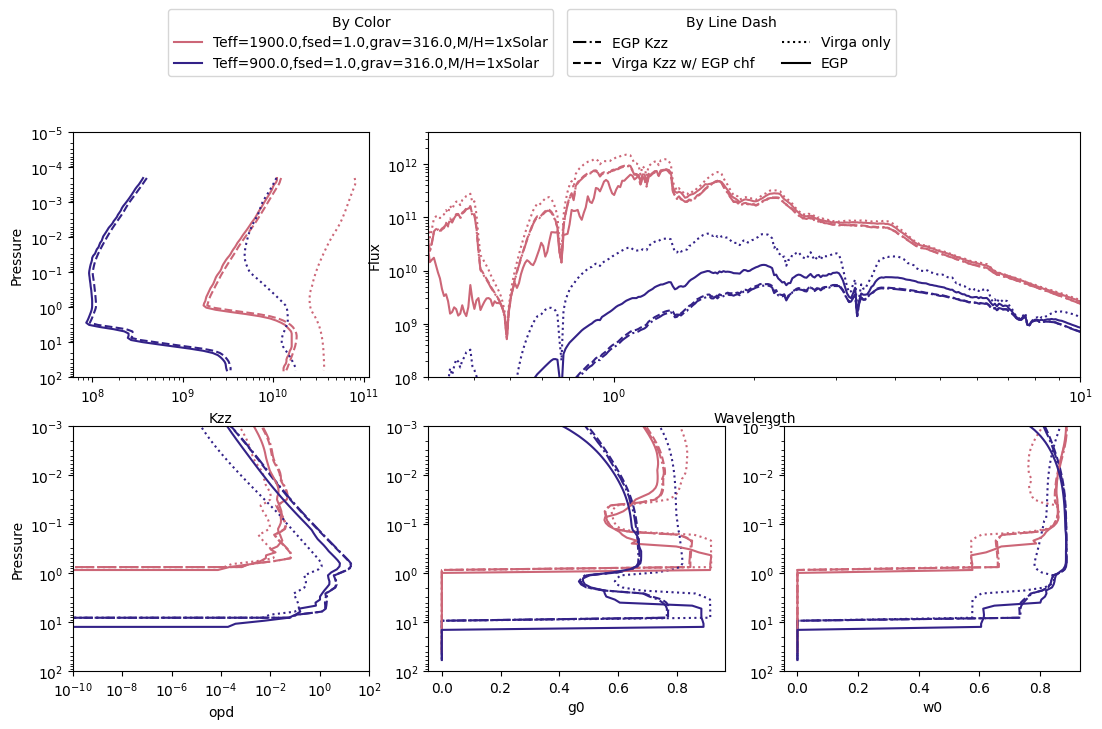

In [12]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(13, 7)) 

gs = gridspec.GridSpec(2, 3, figure=fig)
ax_kzz = fig.add_subplot(gs[0, 0])
ax_spec = fig.add_subplot(gs[0, 1:])
ax_opd = fig.add_subplot(gs[1, 0])
ax_g0 = fig.add_subplot(gs[1, 1])
ax_w0 = fig.add_subplot(gs[1, 2])
plots = {'opd':ax_opd,'g0':ax_g0, 'w0':ax_w0 }

linestyles = ['-.','--','dotted']
colors = pals.Muted4
results ={i:{} for i in labels}

NLAY=90

#loop over models we have
for i,ikey in enumerate(list(db.keys())):  
    #loop over different kz tests we have
    for ii,j ,l in zip([0,1,2],[ALL_kzz,ALL_chf,ALL_v],labels):
        #plot all spectra reproduced from virga/picaso
        ax_spec.plot(1e4/results_spec[ikey][l]['regridx'], results_spec[ikey][l]['regridy'],
                     color=colors[i],linestyle=linestyles[ii])
        #plot all cld properties reproduced from virga
        for iplt in plots.keys(): 
            x = jdi.np.mean(jdi.np.reshape(results_cld[ikey][l][iplt].values,(NLAY,196)),axis=1)
            y = jdi.np.reshape(results_cld[ikey][l]['pressure'].values,(NLAY,196))[:,0]
            plots[iplt].semilogy(x,y,color=colors[i],linestyle=linestyles[ii])

#plot spec from db zenodo
for i,key in enumerate(db.keys()): 
    x,y = pjdi.mean_regrid(1e4/spec[key][0].values, spec[key][1].values,R=100)
    ax_spec.plot(1e4/x,y,
                     color=colors[i],linestyle='solid')

#plot cld direct from diamondback zenodo
for i,ikey in enumerate(list(db.keys())):
    for iplt in plots.keys(): 
        if iplt=='opd':
            lab='tau'
        else: 
            lab = iplt
        x = jdi.np.mean(jdi.np.reshape(cld[ikey][lab].values,(90,196)),axis=1)
        y = db[ikey]['pressure'].values
        plots[iplt].semilogy(x,y, color=colors[i],linestyle='solid')

#plot kzz
linestyles = ['solid','--','dotted']
colors = pals.Muted4
for i,ikey in enumerate(list(db.keys())):
    for ii,j in zip([0,1,2],[ALL_kzz,ALL_chf,ALL_v]):
        kzz = j[ikey].kz
        ax_kzz.loglog(kzz,pressure[1:],color=colors[i],linestyle=linestyles[ii])


#lots of plot styles 
ax_kzz.set_ylim([1e2,1e-5])

for iplt in plots.keys(): 
    plots[iplt].set_ylim([1e2,1e-3])
    plots[iplt].set_xlabel(iplt)
plots['opd'].set_xscale('log')
plots['opd'].set_xlim([1e-10,100
                      ])


ax_spec.set_yscale('log')
ax_spec.set_xscale('log')
ax_spec.set_ylim([1e8,4e12])
ax_spec.set_xlim([0.4,10])
ax_spec.set_xlabel('Wavelength')
ax_spec.set_ylabel('Flux')

ax_kzz.set_xlabel('Kzz')
ax_kzz.set_ylabel('Pressure')
plots['opd'].set_ylabel('Pressure')


colors = pals.Muted4
results ={i:{} for i in labels}

color_handles = []
for j,i in enumerate(list(db.keys())):   
    fsed =float( i[i.find('f')+1:i.find('_m')])
    grav =float( i[i.find('g')+1:i.find('f')])
    teff =float( i[i.find('t')+1:i.find('g')])
    lb = f'Teff={teff},fsed={fsed},grav={grav},M/H=1xSolar'
    color_handles.append(mlines.Line2D([], [], color=colors[j], linestyle='-', label=lb))

linestyle_handles = []
linestyles = ['-.','--','dotted','solid']
for ii,j ,l in zip([0,1,2,3],[ALL_kzz,ALL_chf,ALL_v,0],['EGP Kzz','Virga Kzz w/ EGP chf','Virga only','EGP']):
    linestyle_handles.append(mlines.Line2D([], [], color='black', linestyle=linestyles[ii], label=l))

legend1 = fig.legend(handles=color_handles, title='By Color',
                    loc='lower right', bbox_to_anchor=(0.5, 0.95), ncol=1)


legend2 = fig.legend(handles=linestyle_handles, title='By Line Dash',
                    loc='lower left', bbox_to_anchor=(0.5,  0.95), ncol=2)

